##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Monte Carlo Pricing in Tensorflow Quant Finance (TFF) using Euler Scheme

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [0]:
#@title Install TF Quant Finance
!pip install tf-quant-finance

In [0]:
#@title Install QuantLib
!pip install QuantLib-Python

 ### Setup Euler Scheme for Diffusion Sampling
   Diffusion process $X(t) = (X_1(t), .. X_n(t))$ is a solution to a [Stochastic Differential Equation](https://en.wikipedia.org/wiki/Stochastic_differential_equation) (SDE)
   $$dS_i = a_i(t, S) dt + \sum_{j=1}^n S_{ij} (t, S) dW_j,\ i \in \{1,.., n\},$$

where $n$ is the dimensionality of the diffusion, $\{W_j\}_{j=1}^n$ is $n$-dimensitonal Brownian motion, $a_i(t, S)$ is the instantaneous drift rate and the $S_{ij}(t)$ is the
volatility matrix.

In this colab we demonstrate how to draw samples from an approximate solution in TFF using the [Euler scheme](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method).


In [0]:
#@title Imports { display-mode: "form" }

import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf

 # tff for Tensorflow Finance
import tf_quant_finance as tff
ItoProcess = tff.models.ItoProcess

from IPython.core.pylabtools import figsize
figsize(21, 14) # better graph size for Colab  


In [0]:
#@title Define Euler Scheme for Diffusion sampling

# Note that Euler scheme is a built-in sampling algorithm provided both drift
# and volatility funcitons are provided
 
class ExampleProcess(ItoProcess):
  def __init__(self, dim, drift_fn, vol_fn, dtype=tf.float64):
    self._dim = dim
    self._drift_fn = drift_fn
    self._vol_fn = vol_fn
    self._dtype = dtype

  def dim(self):
    return self._dim

  def drift_fn(self):
    return self._drift_fn

  def volatility_fn(self):
    return self._vol_fn

  def dtype(self):
    return self._dtype

  def name(self):
    return 'ito_process'


## European option pricing. Performance comparison with QuantLib

TODO: demonstrate batching on strikes using TFF.

In [0]:
#@title Set up parameters
tf.reset_default_graph()

dtype = np.float64
num_samples = 100000 #@param

dim = 1 #@param

num_timesteps = 500 #@param

times = [1.0] 
dt = 1. / num_timesteps
rate = tf.constant([0.03], dtype=dtype)
sigma = tf.constant([0.1], dtype=dtype)
spot = tf.constant([700], dtype=dtype)
log_spot = tf.log(tf.reduce_mean(spot))

strike = 550

def drift_fn(t, x):
  del t, x
  return rate - 0.5 * sigma**2

def vol_fn(t, x):
  del t, x
  return sigma * tf.eye(dim, dtype=dtype)



In [0]:
#@title Sampling on a CPU. Note TensorFlow does automatic multithreading.
with tf.device("/cpu:0"):
  process = ExampleProcess(dim=dim, drift_fn=drift_fn, vol_fn=vol_fn, dtype=dtype)
  paths = process.sample_paths(times, num_samples=num_samples,
                               initial_state=log_spot,
                               seed=10, grid_step=dt)
  price = tf.exp(-rate * times) * tf.reduce_mean(
      tf.nn.relu(tf.exp(paths) - strike), [0, 1]) 

with tf.Session() as sess:
  sess.run(log_spot)  # warm-up the kernel

with tf.Session() as sess:
  time_start = time.time()
  price_cpu = sess.run(price)
  time_end = time.time()

time_price_cpu = time_end - time_start
print("Time (seconds) to price a European Call Option on a CPU: ", time_price_cpu)

('Time (seconds) to price a European Call Option on a CPU: ', 1.5947520732879639)


In [0]:
#@title Monte Carlo sampling in QuantLib

num_samples = 100000 #@param

num_timesteps = 500 #@param

expiry = 1.0

calculation_date = ql.Date(1, 1, 2010)
maturity_date = ql.Date(1, 1, 2011)
day_count = ql.Thirty360()
calendar = ql.NullCalendar()

ql_strike_price = 550
sigma = 0.1
ql_volatility = ql.SimpleQuote(sigma)
ql_risk_free_rate = 0.03
option_type = ql.Option.Call

ql.Settings.instance().evaluationDate = calculation_date
payoff = ql.PlainVanillaPayoff(option_type, ql_strike_price)

eu_exercise = ql.EuropeanExercise(maturity_date)
european_option_ql = ql.VanillaOption(payoff, eu_exercise)

flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, ql_risk_free_rate, day_count)
)
flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar,
                        ql.QuoteHandle(ql_volatility), day_count)
)

spot = 700
spot_price = ql.SimpleQuote(spot)
spot_handle = ql.QuoteHandle(
    spot_price
)
bsm_process = ql.BlackScholesProcess(spot_handle,
                                      flat_ts,
                                      flat_vol_ts)

# Compute the same price number_of_options times

engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                             timeSteps=num_timesteps,
                             requiredSamples=num_samples,
                             seed=42)

# Price
t = time.time()
european_option_ql.setPricingEngine(engine)
price_ql = european_option_ql.NPV()
time_price_ql = time.time() - t
print("Time (seconds) to price a European Call Option using QuantLib: ", time_price_ql)


('Time (seconds) to price a European Call Option using QuantLib: ', 31.67402410507202)


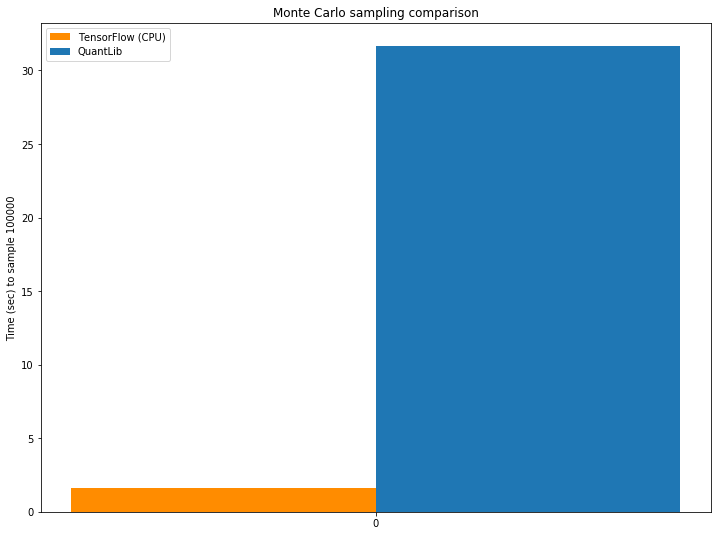

In [0]:
#@title Plot the results

ind = np.arange(1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(12)

rects1 = ax.bar(ind - width/2, [time_price_cpu], width,
                label='TensorFlow (CPU)', color='darkorange')
rects2 = ax.bar(ind + width/2, [time_price_ql], width,
                label='QuantLib')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec) to sample {}'.format(num_samples))
ax.set_title('Monte Carlo sampling comparison')
ax.set_xticks(ind)
ax.legend()


plt.show()

## Sampling from a 100-dimensional process. GPU vs CPU comparison

In [0]:
#@title Set up SDE parameters
tf.reset_default_graph()

dtype = np.float64
num_samples = 100000 #@param

dim = 100 #@param

num_timesteps = 500 #@param

times = [0.1, 0.5, 1.0]  # Return sample paths at 3 different times
dt = 1. / num_timesteps

# Sampling from dX = 0.1 * dt + cov * dW

def drift_fn(t, x):
  del t, x
  return 0.1 + tf.zeros([dim], dtype=dtype)

# Generate random covariance matrix
np.random.seed(42)  # set random seed
matrix_decomposition = np.random.uniform(size=[dim, dim])
cov = np.dot(matrix_decomposition, matrix_decomposition.transpose())

def vol_fn(t, x):
  del t, x
  return matrix_decomposition


In [0]:
#@title Sampling on a CPU. Note TensorFlow does automatic multithreading.
with tf.device("/cpu:0"):
  process = ExampleProcess(dim=dim, drift_fn=drift_fn, vol_fn=vol_fn)
  paths = process.sample_paths(times, num_samples=num_samples,
                               initial_state=np.zeros([dim]),
                               seed=10, grid_step=dt) 

with tf.Session() as sess:
  sess.run(tf.constant(0))  # warm-up the kernell

with tf.Session() as sess:
  time_start = time.time()
  paths_cpu = sess.run(paths)
  time_end = time.time()

time_price_cpu = time_end - time_start
print("Time (seconds) to sample {} paths on a CPU: ".format(num_samples), time_price_cpu)

('Time (seconds) to sample 100000 paths on a CPU: ', 89.0434639453888)


In [0]:
#@title Sampling on a GPU.
with tf.device("/gpu:0"):
  process = ExampleProcess(dim=dim, drift_fn=drift_fn, vol_fn=vol_fn)
  paths = process.sample_paths(times, num_samples=num_samples,
                               initial_state=np.zeros([dim]),
                               seed=10, grid_step=dt) 

with tf.Session() as sess:
  sess.run(tf.constant(0))  # warm-up the kernel

with tf.Session() as sess:
  time_start = time.time()
  paths_gpu = sess.run(paths)
  time_end = time.time()

time_price_gpu = time_end - time_start
print("Time (seconds) to sample {} paths on a GPU: ".format(num_samples), time_price_gpu)

('Time (seconds) to sample 100000 paths on a GPU: ', 13.390123128890991)


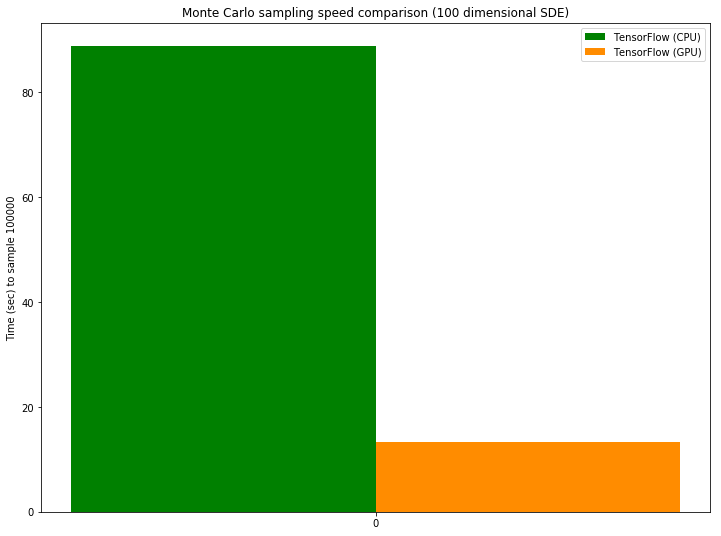

In [0]:
#@title Plot the results

ind = np.arange(1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(12)

rects1 = ax.bar(ind - width/2, [time_price_cpu], width,
                label='TensorFlow (CPU)', color='green')
rects2 = ax.bar(ind + width/2, [time_price_gpu], width,
                label='TensorFlow (GPU)', color='darkorange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec) to sample {}'.format(num_samples))
ax.set_title('Monte Carlo sampling speed comparison (100 dimensional SDE)')
ax.set_xticks(ind)
ax.legend()

plt.show()

# Work in progress: demonstrate automatic differentiation capabilities of TFF